# LMUNet: Landscape metrics unet

**ORIGINAL SOURCE:** [Top 100 solution - SIIM-ACR Pneumothorax Segmentation](https://amaarora.github.io/2020/09/06/siimacr.html#train-and-valid-augmentations)

The Data-structure should look like this (old names: 

```
├── data
│   ├── dataset512
│   ├── dicom-images-test
│   └── dicom-images-train
└── src
    └── pneumothorax-segmentation 
```


## a)  The imports may be adjusted reducing obsolete ones

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
#import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch.nn as nn
#from torch.nn import MSELoss
from collections import defaultdict
import torchvision
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import Sampler
import sys; sys.path.append('../pneumothorax-segmentation/unet_pipeline/')
from Losses import ComboLoss, dice_metric

In [2]:
#import tqdm
try:
    get_ipython().__class_._name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

## b) Config (Hyperparameters)

The [ComboLoss](https://github.com/sneddy/pneumothorax-segmentation/blob/master/unet_pipeline/Losses.py#L104) function used in CRITERION below also comes from the winning solution by Anuar. 

```
Adjust:
    - file paths
    - batch size
    - learning rate
    - epochs
    - criterion (=loss function)
    - train or evaluate
    - etc
```

In [3]:
IMG_SIZE         = 128
#DATA_DIR         = Path(f'../data/dataset{IMG_SIZE}/')
DATA_DIR         = Path(f'../notebooks/data')
#DATA_DIR         = Path(f'/data')
#TRAIN_IMG_DIR    = DATA_DIR/'npy_10000_random_ls'
#TRAIN_LBL_DIR    = DATA_DIR/'npy_10000_random_moving_window_sidi'
TRAIN_IMG_DIR    = DATA_DIR/'npy_3_class_lsm_l_sidi_5_mov_win'
#TRAIN_LBL_DIR    = DATA_DIR/'100k_landscapes_04'
TRAIN_LBL_DIR    = DATA_DIR/'100k_landscapes_3_classes_reordered' # right order of HxCxW
#RLE_DF           = pd.read_csv('../data/train-rle.csv', names=['ImageId', 'EncodedPixels'], skiprows=1)
#RLE_DF           = pd.read_csv('data/metric_list_reti_futu.csv', names=['ImageId', 'EncodedPixels'], skiprows=1)
RLE_DF           = pd.read_csv('data/100k_metr_ls.csv', header=None)
#RLE_DF           = pd.read_csv('data/metric_list_reti_futu.csv', header=None)
#KFOLD_PATH       = '../data/RLE_kfold.csv'
TRAIN_BATCH_SIZE = 14
VALID_BATCH_SIZE = 14
USE_SAMPLER      = False
POSTIVE_PERC     = 0.8
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
#CLASSES          = ['mask']
ACTIVATION       = None 
DEVICE           = 'cuda'
#PRETRAINED_PATH  = '../data/bst_model512_fold2_0.9565.bin'
#PRETRAINED       = True
LEARNING_RATE    = 2e-5
#LEARNING_RATE    = 0.1
#LEARNING_RATE    = 0.01
EPOCHS           = 50
LOSS_FN          = 'mixed'
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})
USE_CRIT         = True
TRAIN_MODEL      = True
EVALUATE         = False
FOLD_ID          = 4
#SUBMIT_TO_KAGGLE = False

## c) Utils

General utility functions provided by Kaggle to perform perform run length encoding and decoding.

In [4]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

In [5]:
def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [6]:
'''
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.imshow(img.permute(1,2,0).numpy())
'''

'\ndef matplotlib_imshow(img, one_channel=False):\n    fig,ax = plt.subplots(figsize=(10,6))\n    ax.imshow(img.permute(1,2,0).numpy())\n'

## d) Visualization functions

In [7]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(img.permute(1,2,0).numpy())

In [8]:
'''
def visualize(**images):
    """PLot images in one row."""
    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    n = len(images)
    plt.figure(figsize=(16, 8))
    image, mask = images['image'], images['mask']
    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)
    if mask.max()>0:
        plt.imshow(mask.squeeze(0), alpha=0.25)
    plt.show()
'''

'\ndef visualize(**images):\n    """PLot images in one row."""\n    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy \n    n = len(images)\n    plt.figure(figsize=(16, 8))\n    image, mask = images[\'image\'], images[\'mask\']\n    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)\n    if mask.max()>0:\n        plt.imshow(mask.squeeze(0), alpha=0.25)\n    plt.show()\n'

In [9]:
'''
def visualize(landscape, metric):
    """PLot images in one row."""
    #landscapes = {k:v.numpy() for k,v in landscapes.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    #landscape = landscape.numpy()
    #metric = metric.numpy()
    #n = len(landscapes)
    columns = 2
    rows = 1
    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(rows, columns, 1)
    plt.title("Landscape")
    #landscape, metric = landscapes['landscape'], landscapes['metric']
    #plt.imshow(landscape.transpose(1,2,0), vmin=0, vmax=1)
    plt.imshow(landscape)
    fig.add_subplot(rows, columns, 2)
    plt.title("Metric")
    plt.imshow(metric)
    #if metric.max()>0:
    #    plt.imshow(metric.squeeze(0), alpha=0.25)
    plt.show()
    
'''

'\ndef visualize(landscape, metric):\n    """PLot images in one row."""\n    #landscapes = {k:v.numpy() for k,v in landscapes.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy \n    #landscape = landscape.numpy()\n    #metric = metric.numpy()\n    #n = len(landscapes)\n    columns = 2\n    rows = 1\n    fig = plt.figure(figsize=(8, 8))\n    fig.add_subplot(rows, columns, 1)\n    plt.title("Landscape")\n    #landscape, metric = landscapes[\'landscape\'], landscapes[\'metric\']\n    #plt.imshow(landscape.transpose(1,2,0), vmin=0, vmax=1)\n    plt.imshow(landscape)\n    fig.add_subplot(rows, columns, 2)\n    plt.title("Metric")\n    plt.imshow(metric)\n    #if metric.max()>0:\n    #    plt.imshow(metric.squeeze(0), alpha=0.25)\n    plt.show()\n    \n'

In [10]:
def visualize(metric, landscape):
    """PLot images in one row."""
    #landscapes = {k:v.numpy() for k,v in landscapes.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    #landscape = landscape.numpy()
    #metric = metric.numpy()
    #n = len(landscapes)
    columns = 2
    rows = 1
    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(rows, columns, 1)
    plt.title("Metric")
    #landscape, metric = landscapes['landscape'], landscapes['metric']
    #plt.imshow(landscape.transpose(1,2,0), vmin=0, vmax=1)
    plt.imshow(metric)
    fig.add_subplot(rows, columns, 2)
    plt.title("Landscape")
    plt.imshow(landscape)
    #if metric.max()>0:
    #    plt.imshow(metric.squeeze(0), alpha=0.25)
    plt.show()

## Dataset

### e) Create five-fold splits

In [11]:
'''
# create 5 folds train file if it doesn't exist already
if not os.path.exists(KFOLD_PATH):
    RLE_DF['has_mask'] = 0
    RLE_DF.loc[RLE_DF.EncodedPixels!='-1', 'has_mask'] = 1
    kf = StratifiedKFold()
    RLE_DF['kfold']=-1
    for fold, (train_index, test_index) in enumerate(kf.split(X=RLE_DF.ImageId, y=RLE_DF.has_mask)):
            RLE_DF.loc[test_index, 'kfold'] = fold
    RLE_DF.to_csv('../data/RLE_kfold.csv', index=False)
'''

"\n# create 5 folds train file if it doesn't exist already\nif not os.path.exists(KFOLD_PATH):\n    RLE_DF['has_mask'] = 0\n    RLE_DF.loc[RLE_DF.EncodedPixels!='-1', 'has_mask'] = 1\n    kf = StratifiedKFold()\n    RLE_DF['kfold']=-1\n    for fold, (train_index, test_index) in enumerate(kf.split(X=RLE_DF.ImageId, y=RLE_DF.has_mask)):\n            RLE_DF.loc[test_index, 'kfold'] = fold\n    RLE_DF.to_csv('../data/RLE_kfold.csv', index=False)\n"

In [12]:
'''
# single fold training for now, rerun notebook to train for multi-fold
DF       = pd.read_csv(KFOLD_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)
VAL_DF   = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)
len(TRAIN_DF), len(VAL_DF)
'''

"\n# single fold training for now, rerun notebook to train for multi-fold\nDF       = pd.read_csv(KFOLD_PATH)\nTRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)\nVAL_DF   = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)\nlen(TRAIN_DF), len(VAL_DF)\n"

### f) Dataset and DataLoaders

In [13]:
'''
class Dataset():
    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None):
        self.df             = rle_df
        self.image_base_dir = image_base_dir
        self.masks_base_dir = masks_base_dir
        self.image_ids      = rle_df.ImageId.values
        self.augmentation   = augmentation
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(self.image_base_dir, image_id+'.png') 
        mask_path = os.path.join(self.masks_base_dir, image_id+'.png')
        image     = cv2.imread(img_path, 1)
        mask      = cv2.imread(mask_path, 0)     
        
        # apply augmentations
        if self.augmentation:
            sample = {"image": image, "mask": mask}
            sample = self.augmentation(**sample)
            image, mask = sample['image'], sample['mask']

        return {
            'image': image, 
            'mask' : mask
        }
        
    def __len__(self):
        return len(self.image_ids)
'''

'\nclass Dataset():\n    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None):\n        self.df             = rle_df\n        self.image_base_dir = image_base_dir\n        self.masks_base_dir = masks_base_dir\n        self.image_ids      = rle_df.ImageId.values\n        self.augmentation   = augmentation\n    \n    def __getitem__(self, i):\n        image_id  = self.image_ids[i]\n        img_path  = os.path.join(self.image_base_dir, image_id+\'.png\') \n        mask_path = os.path.join(self.masks_base_dir, image_id+\'.png\')\n        image     = cv2.imread(img_path, 1)\n        mask      = cv2.imread(mask_path, 0)     \n        \n        # apply augmentations\n        if self.augmentation:\n            sample = {"image": image, "mask": mask}\n            sample = self.augmentation(**sample)\n            image, mask = sample[\'image\'], sample[\'mask\']\n\n        return {\n            \'image\': image, \n            \'mask\' : mask\n        }\n        \n    def

### g) Data augmentation ("transforms")

In [14]:
'''
# Train transforms
TFMS = albu.Compose([
    albu.HorizontalFlip(),
    albu.Rotate(10),
    albu.Normalize(),
    ToTensorV2(),
])

# Test transforms
TEST_TFMS = albu.Compose([
    albu.Normalize(),
    ToTensorV2(),
])
'''

'\n# Train transforms\nTFMS = albu.Compose([\n    albu.HorizontalFlip(),\n    albu.Rotate(10),\n    albu.Normalize(),\n    ToTensorV2(),\n])\n\n# Test transforms\nTEST_TFMS = albu.Compose([\n    albu.Normalize(),\n    ToTensorV2(),\n])\n'

In [15]:
'''
# Train transforms
TFMS = albu.Compose([
    albu.HorizontalFlip(),
    albu.Rotate(10),
    albu.Normalize(),
    ToTensorV2(),
    torch.unsqueeze(dim=0),
])

# Test transforms
TEST_TFMS = albu.Compose([
    albu.Normalize(),
    ToTensorV2(),
    torch.unsqueeze(dim=0),
])
'''


x = torch.randn(128, 128)
x = x[None,:, :]
x.shape

torch.Size([1, 128, 128])

In [16]:
#from Dataset_test import LandscapeMetricsDataset
from Dataset_test_metr_ls import LandscapeMetricsDataset

In [17]:
'''#from Dataset_test import LandscapeMetricsDataset
from Dataset_test_metr_ls import LandscapeMetricsDataset
landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, metrics_dir=TRAIN_IMG_DIR, landscape_dir=TRAIN_LBL_DIR)
'''

'#from Dataset_test import LandscapeMetricsDataset\nfrom Dataset_test_metr_ls import LandscapeMetricsDataset\nlandscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, metrics_dir=TRAIN_IMG_DIR, landscape_dir=TRAIN_LBL_DIR)\n'

In [18]:
'''
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TFMS) 
val_dataset   = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TEST_TFMS) 
'''

'\ntrain_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TFMS) \nval_dataset   = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TEST_TFMS) \n'

In [19]:
landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, metrics_dir=TRAIN_IMG_DIR, landscape_dir=TRAIN_LBL_DIR)
#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR)
#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR, augmentation=TFMS)

In [20]:
landscapes_dataset[50]

{'metric': tensor([[[0.6420, 0.6528, 0.6578,  ..., 0.6667, 0.6528, 0.5926],
          [0.6528, 0.6250, 0.6400,  ..., 0.6550, 0.6328, 0.5694],
          [0.6578, 0.6350, 0.6144,  ..., 0.6368, 0.6150, 0.5511],
          ...,
          [0.4178, 0.5150, 0.5184,  ..., 0.4736, 0.4850, 0.5511],
          [0.2778, 0.4062, 0.4600,  ..., 0.4850, 0.4688, 0.5000],
          [0.1975, 0.4028, 0.4800,  ..., 0.4800, 0.5000, 0.4444]]]),
 'landscape': tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          [1., 0., 0.,  ..., 1., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 1., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0., 

In [21]:
len(landscapes_dataset)

95954

In [22]:
# https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
# split dataset into training and testing. 
# rando generator seed for reproducabitly included!
from torch.utils.data import DataLoader, random_split

# split dataset
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[1000,84000,10955], generator=torch.Generator().manual_seed(42))
train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[75000,10000,10954], generator=torch.Generator().manual_seed(42))
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[750,125,125], generator=torch.Generator().manual_seed(42))


In [23]:
# sanity check
#landscape, metric = train_dataset[136]['landscape'], train_dataset[136]['metric']
metric, landscape = train_dataset[1]['metric'], train_dataset[1]['landscape']
#landscape = train_dataset[1]['landscape']

landscape.shape, metric.shape
#landscape.shape, metric.shape

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

In [24]:
#open(os_fspath('/notebooks/data/100k_landscapes_04/metr_84094517.npy'), "rb")
#landscape = np.load('data/100k_landscapes_04/ls_10000212.npy')
#metric = np.load('/data/npy_3_class_lsm_sidi_5_mov_win/metr_10049667.npy')
#metric = np.load('data/npy_3_class_lsm_sidi_5_mov_win/metr')

#metric = np.load('data/npy_3_class_lsm_l_sidi_5_mov_win/metr_84094517.npy')

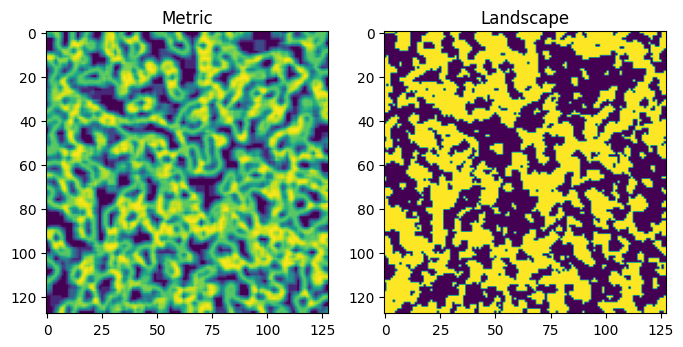

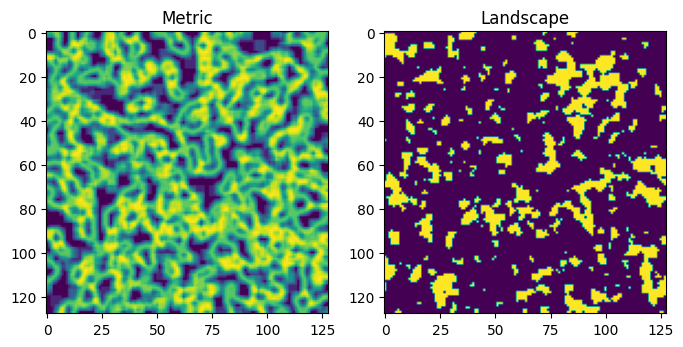

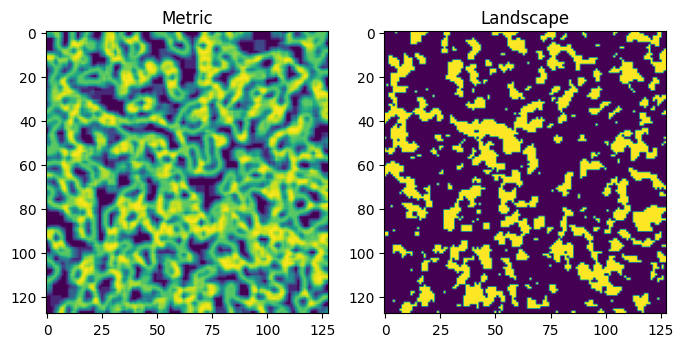

In [25]:
# plot one with mask 
#visualize(train_dataset[137]['landscape'].squeeze(), train_dataset[137]['metric'].squeeze())
visualize(train_dataset[137]['metric'].squeeze(), train_dataset[137]['landscape'][1].squeeze())
visualize(train_dataset[137]['metric'].squeeze(), train_dataset[137]['landscape'][2].squeeze())
visualize(train_dataset[137]['metric'].squeeze(), train_dataset[137]['landscape'][0].squeeze())

### h) Sampler

A sampler similar to the [winning solution](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/107824) used by [Anuar Aimoldin](https://www.linkedin.com/in/anuar-aimoldin/) to help with easy convergence. (not used as part of this solution, but provided for the reader to experiment) 

In [26]:
'''
class PneumoSampler(Sampler):
    def __init__(self, train_df, positive_perc=0.8):
        assert positive_perc > 0, 'percentage of positive pneumothorax images must be greater then zero'
        self.train_df = train_df
        self.positive_perc = positive_perc
        self.positive_idxs = self.train_df.query('has_mask==1').index.values
        self.negative_idxs = self.train_df.query('has_mask!=1').index.values
        self.n_positive = len(self.positive_idxs)
        self.n_negative = int(self.n_positive * (1 - self.positive_perc) / self.positive_perc)
        
    def __iter__(self):
        negative_sample = np.random.choice(self.negative_idxs, size=self.n_negative)
        shuffled = np.random.permutation(np.hstack((negative_sample, self.positive_idxs)))
        return iter(shuffled.tolist())

    def __len__(self):
        return self.n_positive + self.n_negative
        
        '''

"\nclass PneumoSampler(Sampler):\n    def __init__(self, train_df, positive_perc=0.8):\n        assert positive_perc > 0, 'percentage of positive pneumothorax images must be greater then zero'\n        self.train_df = train_df\n        self.positive_perc = positive_perc\n        self.positive_idxs = self.train_df.query('has_mask==1').index.values\n        self.negative_idxs = self.train_df.query('has_mask!=1').index.values\n        self.n_positive = len(self.positive_idxs)\n        self.n_negative = int(self.n_positive * (1 - self.positive_perc) / self.positive_perc)\n        \n    def __iter__(self):\n        negative_sample = np.random.choice(self.negative_idxs, size=self.n_negative)\n        shuffled = np.random.permutation(np.hstack((negative_sample, self.positive_idxs)))\n        return iter(shuffled.tolist())\n\n    def __len__(self):\n        return self.n_positive + self.n_negative\n        \n        "

In [27]:
'''
SAMPLER = PneumoSampler(TRAIN_DF, positive_perc=POSTIVE_PERC)
'''

'\nSAMPLER = PneumoSampler(TRAIN_DF, positive_perc=POSTIVE_PERC)\n'

### i) DataLoaders

In [28]:
# dataloaders
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=True if not USE_SAMPLER else False, 
                              num_workers=12, 
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(val_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=12)

In [29]:
# sanity check
landscapes, metrics = next(iter(train_dataloader))['landscape'], next(iter(train_dataloader))['metric']
landscapes.shape, metrics.shape
# should look like this: (torch.Size([14, 3, 512, 512]), torch.Size([14, 1, 512, 512]))

(torch.Size([14, 3, 128, 128]), torch.Size([14, 1, 128, 128]))

In [30]:
# plot train images
#ls_grid = torchvision.utils.make_grid(landscapes[:9], nrow=3, normalize=True)
#matplotlib_imshow(ls_grid)

## Model and Training

### j) Loss

In this script we use [ComboLoss](https://github.com/sneddy/pneumothorax-segmentation/blob/master/unet_pipeline/Losses.py#L104) from winning solution but it is also possible to use `MixedLoss` shared below if `USE_CRIT` is set to `False` in CONFIG.

In [31]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [32]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [33]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [34]:
# pixel wise mse loss
def pixel_wise_mse_loss(input, target):
    return torch.mean((input - target)**2)

### k) Model

From [PyTorch Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch):

In [35]:
#original
'''
import segmentation_models_pytorch as smp
#import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=3,     
    #classes=len(CLASSES), 
    activation=ACTIVATION,
)
'''

'\nimport segmentation_models_pytorch as smp\n#import segmentation_models_pytorch as smp\n\nmodel = smp.Unet(\n    encoder_name=ENCODER, \n    encoder_weights=ENCODER_WEIGHTS, \n    classes=3,     \n    #classes=len(CLASSES), \n    activation=ACTIVATION,\n)\n'

In [36]:
# importen just_unet
#from Just_Unet import unet
from unet_multiclass import unet

torch.Size([1, 64, 124, 124])
torch.Size([1, 128, 58, 58])
torch.Size([1, 256, 25, 25])
torch.Size([1, 512, 8, 8])


In [37]:
model = unet

### l) Early Stopping

In [38]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

### m) Training

In [39]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [40]:
'''
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()
    model = model.to(device)
    model.train()
    if accumulation_steps > 1: 
        optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        for key, value in data.items():
            data[key] = value.to(device)
        if accumulation_steps == 1 and b_idx == 0:
            optimizer.zero_grad()
        out  = model(data['image'])
        loss = loss_fn(out, data['mask'])
        with torch.set_grad_enabled(True):
            loss.backward()
            if (b_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg
    
'''

"\ndef train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):\n    losses = AverageMeter()\n    model = model.to(device)\n    model.train()\n    if accumulation_steps > 1: \n        optimizer.zero_grad()\n    tk0 = tqdm(train_loader, total=len(train_loader))\n    for b_idx, data in enumerate(tk0):\n        for key, value in data.items():\n            data[key] = value.to(device)\n        if accumulation_steps == 1 and b_idx == 0:\n            optimizer.zero_grad()\n        out  = model(data['image'])\n        loss = loss_fn(out, data['mask'])\n        with torch.set_grad_enabled(True):\n            loss.backward()\n            if (b_idx + 1) % accumulation_steps == 0:\n                optimizer.step()\n                optimizer.zero_grad()\n        losses.update(loss.item(), train_loader.batch_size)\n        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])\n    return losses.avg\n    \n"

In [41]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()
    model = model.to(device)
    model.train()
    if accumulation_steps > 1: 
        optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        for key, value in data.items():
            data[key] = value.to(device)
        if accumulation_steps == 1 and b_idx == 0:
            optimizer.zero_grad()
        out  = model(data['metric'])
        loss = loss_fn(out, data['landscape'])
        with torch.set_grad_enabled(True):
            loss.backward()
            if (b_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg

### n) Evaluation Metric

In [42]:
# pixel-wise accuracy
def acc_metric(input, target):
    inp = torch.where(input>0.5, torch.tensor(1, device='cuda'), torch.tensor(0, device='cuda'))
    acc = (inp.squeeze(1) == target).float().mean()
    return acc

In [43]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch

def metric(probability, truth, threshold=0.5, reduction='none'):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice

In [44]:
def evaluate(valid_loader, model, device='cuda', metric=dice_metric):
    losses = AverageMeter()
    model = model.to(device)
    model.eval()
    tk0 = tqdm(valid_loader, total=len(valid_loader))
    with torch.no_grad():
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
            out   = model(data['metric'])
            out   = torch.sigmoid(out)
            dice  = metric(out, data['landscape']).cpu()
            losses.update(dice.mean().item(), valid_loader.batch_size)
            tk0.set_postfix(dice_score=losses.avg)
    return losses.avg

In [45]:
'''
if PRETRAINED: 
    model.load_state_dict(torch.load(PRETRAINED_PATH))
'''

'\nif PRETRAINED: \n    model.load_state_dict(torch.load(PRETRAINED_PATH))\n'

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

### o) Train model

In [47]:
from torch.nn import CrossEntropyLoss

criterion = MixedLoss(10.0, 2.0) if not USE_CRIT else CRITERION 
#criterion = MSELoss
#criterion = pixel_wise_mse_loss
#criterion = CrossEntropyLoss()
es = EarlyStopping(patience=3, mode='max')
#es = EarlyStopping(patience=10, mode='max')

In [48]:
criterion

ComboLoss(
  (bce): StableBCELoss()
  (dice): DiceLoss()
  (jaccard): JaccardLoss()
  (lovasz): LovaszLoss()
  (lovasz_sigmoid): LovaszLossSigmoid()
  (focal): FocalLoss2d()
)

In [54]:
if TRAIN_MODEL:
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
        dice = evaluate(val_dataloader, model, metric=metric)
        scheduler.step()
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL DICE: {dice}")
        es(dice, model, model_path=f"../notebooks/data/bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(dice,4)}.bin")
        best_model = f"../notebooks/data/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
        if es.early_stop:
            print('\n\n -------------- EARLY STOPPING -------------- \n\n')
            break
if EVALUATE:
    valid_score = evaluate(val_dataloader, model, metric=metric)
    print(f"Valid dice score: {valid_score}")

100%|██████████| 715/715 [00:11<00:00, 61.73it/s, dice_score=0]


EPOCH: 0, TRAIN LOSS: 3.8614795376623507, VAL DICE: 0.0
Validation score improved (-inf --> 0.0). Model saved at at ../notebooks/data/bst_model128_fold4_0.0.bin!


 25%|██▌       | 1345/5358 [01:11<03:33, 18.80it/s, learning_rate=2e-5, loss=3.86]


KeyboardInterrupt: 

## p) Submission on Test Images (single-model)

In [49]:
'''
class TestDataset():
    def __init__(self, sample_sub, image_base_dir, augmentation=None):
        self.image_base_dir = image_base_dir
        self.image_ids      = sample_sub.ImageId.values
        self.augmentation   = augmentation
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(self.image_base_dir, image_id+'.png') 
        image     = cv2.imread(img_path)
        image     = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)       
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image  = sample['image']

        return {
            'image': image, 
        }
        
    def __len__(self):
        return len(self.image_ids)
'''

"\nclass TestDataset():\n    def __init__(self, sample_sub, image_base_dir, augmentation=None):\n        self.image_base_dir = image_base_dir\n        self.image_ids      = sample_sub.ImageId.values\n        self.augmentation   = augmentation\n    \n    def __getitem__(self, i):\n        image_id  = self.image_ids[i]\n        img_path  = os.path.join(self.image_base_dir, image_id+'.png') \n        image     = cv2.imread(img_path)\n        image     = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)       \n        \n        # apply augmentations\n        if self.augmentation:\n            sample = self.augmentation(image=image)\n            image  = sample['image']\n\n        return {\n            'image': image, \n        }\n        \n    def __len__(self):\n        return len(self.image_ids)\n"

In [50]:
'''
SAMPLE_SUBMISSION = pd.read_csv('/home/ubuntu/repos/kaggle/acr_Pneumothorax/data/stage-2/stage_2_sample_submission.csv')
TEST_IMG_DIR = DATA_DIR/'test'

len(SAMPLE_SUBMISSION)
'''

"\nSAMPLE_SUBMISSION = pd.read_csv('/home/ubuntu/repos/kaggle/acr_Pneumothorax/data/stage-2/stage_2_sample_submission.csv')\nTEST_IMG_DIR = DATA_DIR/'test'\n\nlen(SAMPLE_SUBMISSION)\n"

In [51]:
#from Dataset_test import LandscapeMetricsDataset
from Dataset_test_metr_ls import LandscapeMetricsDataset
landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, metrics_dir=TRAIN_IMG_DIR, landscape_dir=TRAIN_LBL_DIR)
from torch.utils.data import DataLoader, random_split

# split dataset
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[1000,84000,10955], generator=torch.Generator().manual_seed(42))
train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[75000,10000,10954], generator=torch.Generator().manual_seed(42))
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[750,125,125], generator=torch.Generator().manual_seed(42))


In [52]:
'''
test_dataset    = TestDataset(SAMPLE_SUBMISSION, TEST_IMG_DIR, TEST_TFMS)
'''
test_dataloader = DataLoader(test_dataset, 16, shuffle=False, num_workers=12)

In [53]:
model.load_state_dict(torch.load('data/bst_model128_fold4_0.0_ls.bin'))

<All keys matched successfully>

In [54]:
model = model.to('cuda')

In [55]:
def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((128, 128), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [56]:
def predict(test_dataloader, model, device='cuda'):
    encoded_pixels = []
    losses = AverageMeter()
    model = model.to(device)
    model.eval()
    tk0 = tqdm(test_dataloader, total=len(test_dataloader))
    for b_idx, data in enumerate(tk0):
        data['metric'] = data['metric'].to(device)
        out   = model(data['metric'])
        out   = out.detach().cpu().numpy()[:, 0, :, :]
        for out_ in out:
            #import pdb;pdb.set_trace()
            #if out_.shape != (128, 128):
            #    out_ = cv2.resize(out_, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
            predict, num_predict = post_process(out_, 0.5, 3500)
            if num_predict == 0:
                encoded_pixels.append('-1')
            else:
                r = run_length_encode(predict)
                encoded_pixels.append(r)
    return encoded_pixels

In [57]:
prediction = predict(test_dataloader, model)

  0%|          | 0/685 [00:00<?, ?it/s]ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
  1%|          | 7/685 [00:00<01:25,  7.93it/s]


RuntimeError: DataLoader worker (pid(s) 23289) exited unexpectedly

In [ ]:
visualize(test_dataset[4]['landscape'][0].squeeze(),prediction[4][0].squeeze(), left_title= "Metric", right_title = "Prediction")

In [42]:
if SUBMIT_TO_KAGGLE:    
    enc_pixels = predict(test_dataloader, model)

    SAMPLE_SUBMISSION['EncodedPixels'] = enc_pixels
    SAMPLE_SUBMISSION.to_csv('./submission.csv', index=False)

    !kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f submission.csv -m "512x512 fold-2"

## q) Submit to Kaggle - `five fold`

In [43]:
class TestDataset():
    def __init__(self, sample_sub, image_base_dir, augmentation=None):
        self.image_base_dir = image_base_dir
        self.image_ids      = sample_sub.ImageId.values
        self.augmentation   = augmentation
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(self.image_base_dir, image_id+'.png') 
        image     = cv2.imread(img_path)
        image     = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)       
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image  = sample['image']

        return {
            'image_id': image_id,
            'image': image
        }
        
    def __len__(self):
        return len(self.image_ids)

In [44]:
test_dataset    = TestDataset(SAMPLE_SUBMISSION, TEST_IMG_DIR, TEST_TFMS)
test_dataloader = DataLoader(test_dataset, 16, shuffle=False, num_workers=12)

In [45]:
def inference_image(model, images, device='cuda'):
    images = images.to(device)
    predicted = model(images)
    masks = torch.sigmoid(predicted)
    masks = masks.squeeze(1).cpu().detach().numpy()
    return masks

In [46]:
def inference_model(model, loader, device, use_flip=False):
    mask_dict = {}
    for data in tqdm(loader):
        image_ids = data['image_id']
        images    = data['image']
        masks = inference_image(model, images, device)
        for name, mask in zip(image_ids, masks):
            mask_dict[name] = mask.astype(np.float32)
    return mask_dict

In [47]:
# Path to pretrained models from https://www.kaggle.com/aroraaman/siimacr-pretrained/
checkpoints_list=['../data/bst_model512_fold1_0.9492.bin', 
                  '../data/bst_model512_fold2_0.9565.bin', 
                  '../data/bst_model512_fold3_0.9608.bin', 
                  '../data/bst_model512_fold4_0.9604.bin']

In [48]:
mask_dict = defaultdict(int)
for pred_idx, checkpoint_path in enumerate(checkpoints_list):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    current_mask_dict = inference_model(model, test_dataloader, device='cuda')
    for name, mask in current_mask_dict.items():
        mask_dict[name] = (mask_dict[name] * pred_idx + mask) / (pred_idx + 1)

100%|██████████| 201/201 [00:38<00:00,  5.18it/s]


In [49]:
len(mask_dict)

3205

In [50]:
encoded_pixels = []
for image_name, out_ in tqdm(mask_dict.items()):
    if out_.shape != (1024, 1024):
        out_ = cv2.resize(out_, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
    predict, num_predict = post_process(out_, 0.275, 3500)
    if num_predict == 0:
        encoded_pixels.append('-1')
    else:
        r = run_length_encode(predict)
        encoded_pixels.append(r)

100%|██████████| 3205/3205 [00:09<00:00, 344.91it/s]


In [51]:
SAMPLE_SUBMISSION['EncodedPixels'] = encoded_pixels
SAMPLE_SUBMISSION.to_csv('./submission.csv', index=False)

!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f submission.csv -m "512x512 0-4 fold"

100%|█████████████████████████████████████████| 908k/908k [00:07<00:00, 119kB/s]
Successfully submitted to SIIM-ACR Pneumothorax Segmentation

## Model Paths for ensemble
- `../data/bst_model512_0.8193.bin` (fold-0)
- `../data/bst_model512_fold1_0.9492.bin` (fold-1)
- `../data/bst_model512_fold2_0.9565.bin`(fold-2)
- `../data/bst_model512_fold3_0.9608.bin` (fold-3)